In [74]:
import pandas as pd
from datetime import datetime, timedelta, date
import io

colorado_df = pd.read_csv("data/states/colorado/colorado.csv", error_bad_lines=True)
colorado_df = colorado_df[(colorado_df['occcounty'] < 8999)]
weekly_ucode_deaths = colorado_df.groupby(['occcounty', 'year','dwk', 'ucod'])['deaths'].agg(['sum']).reset_index()
weekly_ucode_deaths_df = weekly_ucode_deaths.rename(columns={'occcounty':'county','dwk' : 'week', 'sum':'total_deaths'})

yearly_deaths_by_code = weekly_ucode_deaths_df[(weekly_ucode_deaths_df['week'] <= 34) & (weekly_ucode_deaths_df['year'] == 2019)].groupby(['ucod'])['total_deaths'].sum()
yearly_deaths_by_code_df = yearly_deaths_by_code.to_frame(name = 'yearly_deaths').sort_values(['yearly_deaths', 'ucod'],ascending=False).reset_index().head(30)

top20_ucodes = yearly_deaths_by_code_df['ucod']
weekly_ucode_deaths_df= weekly_ucode_deaths_df[(weekly_ucode_deaths_df['ucod'].isin(top20_ucodes))]


weekly_ucode_deaths_df["excess_deaths"] = 0
avg_ucod_deaths = weekly_ucode_deaths_df[(weekly_ucode_deaths_df['year'] < 2020)].groupby(['county','week','ucod'])['total_deaths'].mean()
avg_ucod_deaths_df = avg_ucod_deaths.to_frame(name = 'avg_ucod_deaths').reset_index()

for index, row in weekly_ucode_deaths_df.iterrows():
    year = row['year']
    county = row['county']
    week = row['week']
    ucod = row['ucod']
    
    if (year == 2020)  :
        avgd = avg_ucod_deaths_df[(avg_ucod_deaths_df['county'] == county) & (avg_ucod_deaths_df['week'] == week) & (avg_ucod_deaths_df['ucod'] == ucod)]
        if not avgd.empty:
            weekly_ucode_deaths_df.at[index, "excess_deaths"] = row['total_deaths'] - avgd['avg_ucod_deaths']      
weekly_ucode_deaths_df["county"] = pd.to_numeric(weekly_ucode_deaths_df["county"], downcast='float')
weekly_ucode_deaths_df = weekly_ucode_deaths_df[weekly_ucode_deaths_df['year'] ==2020]

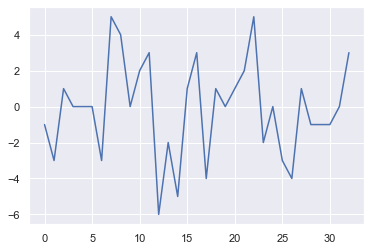

In [75]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
x = weekly_ucode_deaths_df[(weekly_ucode_deaths_df['year'] ==2020) &(weekly_ucode_deaths_df['county'] == 8059.0) &(weekly_ucode_deaths_df['ucod'] == 'J449')]['week']
y = weekly_ucode_deaths_df[(weekly_ucode_deaths_df['year'] ==2020) &(weekly_ucode_deaths_df['county'] == 8059.0)&(weekly_ucode_deaths_df['ucod'] == 'J449')]['excess_deaths']
plt.plot(x, y)

In [76]:
county_covariates= pd.read_csv('https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv').dropna(subset=['FIPS'])
county_covariates = county_covariates[county_covariates['State'] == 'CO']
county_covariates.FIPS = county_covariates.FIPS.astype('int64')
county_covariates=county_covariates.set_index('FIPS')
age_race_df = pd.read_csv('https://docs.google.com/spreadsheets/d/12GIRONjeNHeKFb3EKpo5r-VvdsnTwwe0iOtKBsnZVM0/export?format=csv')
county_icu_beds= pd.read_csv('https://docs.google.com/spreadsheets/d/13iUBUwRcE91_x9FhsF8Ugcb0_tFauWJF2Z-PSkERDlU/export?format=csv')
FIPS = pd.read_csv('https://docs.google.com/spreadsheets/d/1jUwRaTSJ__3Wp60cZLLox5u55mJTZrShtjEK4d7xTEY/export?format=csv')
covariates = age_race_df.merge(county_covariates, how='inner', left_on=["fips"], right_on=['FIPS'])
covariates = covariates.drop(['STNAME', 'County', 'Unnamed: 0','State', 'Area_Name'], axis=1)
covariates = covariates.merge(county_icu_beds, how='inner', left_on=["fips"], right_on=['fips'])
covariates = covariates.drop(['County','State'], axis=1)
covariates = covariates.fillna(0)

covariates = covariates.dropna(axis='columns')

covariates=covariates[['fips',
 'TOT_POP',
 '0-9',
 '0-9 y/o % of total pop',
 '10-19',
 '10-19 y/o % of total pop',
 '20-29',
 '20-29 y/o % of total pop',
 '30-39',
 '30-39 y/o % of total pop',
 '40-49',
 '40-49 y/o % of total pop',
 '50-59',
 '50-59 y/o % of total pop',
 '60-69',
 '60-69 y/o % of total pop',
 '70-79',
 '70-79 y/o % of total pop',
 '80+',
 '80+ y/o % of total pop',
 'White-alone pop',
 '% White-alone',
 'Black-alone pop',
 '% Black-alone',
 'Native American/American Indian-alone pop',
 '% NA/AI-alone',
 'Asian-alone pop',
 '% Asian-alone',
 'Hawaiian/Pacific Islander-alone pop',
 '% Hawaiian/PI-alone',
 'Two or more races pop',
 '% Two or more races',
 'POP_ESTIMATE_2018',
 'N_POP_CHG_2018',
 'GQ_ESTIMATES_2018',
 'R_birth_2018',
 'R_death_2018',
 'R_NATURAL_INC_2018',
 'R_INTERNATIONAL_MIG_2018',
 'R_DOMESTIC_MIG_2018',
 'R_NET_MIG_2018',
 'Less than a high school diploma 2014-18',
 'High school diploma only 2014-18',
 "Some college or associate's degree 2014-18",
 "Bachelor's degree or higher 2014-18",
 'Percent of adults with less than a high school diploma 2014-18',
 'Percent of adults with a high school diploma only 2014-18',
 "Percent of adults completing some college or associate's degree 2014-18",
 "Percent of adults with a bachelor's degree or higher 2014-18",
 'POVALL_2018',
 'PCTPOVALL_2018',
 'PCTPOV017_2018',
 'PCTPOV517_2018',
 'MEDHHINC_2018',
 'CI90LBINC_2018',
 'CI90UBINC_2018',
 'Civilian_labor_force_2018',
 'Employed_2018',
 'Unemployed_2018',
 'Unemployment_rate_2018',
 'Median_Household_Income_2018',
 'Med_HH_Income_Percent_of_State_Total_2018',
 'Jan Precipitation / inch',
 'Feb Precipitation / inch',
 'Mar Precipitation / inch',
 'Apr Precipitation / inch',
 'May Precipitation / inch',
 'Jun Precipitation / inch',
 'Jul Precipitation / inch',
 'Jan Temp AVG / F',
 'Feb Temp AVG / F',
 'Mar Temp AVG / F',
 'Apr Temp AVG / F',
 'May Temp AVG / F',
 'Jun Temp AVG / F',
 'Jul Temp AVG / F',
 'Active Physicians per 100000 Population 2018 (AAMC)',
 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active General Surgeons per 100000 Population 2018 (AAMC)',
 'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)',
 'Total nurse practitioners (2019)',
 'Total physician assistants (2019)',
 'Total Hospitals (2019)',
 'Internal Medicine Primary Care (2019)',
 'Family Medicine/General Practice Primary Care (2019)',
 'Total Specialist Physicians (2019)',
 'ICU Beds_x',
 'Total Population',
 'Population Aged 60+',
 'Percent of Population Aged 60+']]
 

In [77]:
weekly_deaths_prior_two_weeks_df = weekly_ucode_deaths_df.copy() 
weekly_deaths_prior_two_weeks_df["week"] = weekly_deaths_prior_two_weeks_df["week"] + 2
weekly_deaths_prior_two_weeks_df.rename(columns = {'total_deaths':'two_week_prior_total_deaths', 'excess_deaths':'two_week_prior_excess_deaths'}, inplace = True)
weekly_deaths_prior_three_weeks_df = weekly_ucode_deaths_df.copy() 
weekly_deaths_prior_three_weeks_df["week"] = weekly_deaths_prior_three_weeks_df["week"] + 3
weekly_deaths_prior_three_weeks_df.rename(columns = {'total_deaths':'three_week_prior_total_deaths', 'excess_deaths':'three_week_prior_excess_deaths'}, inplace = True)
weekly_deaths_merged_df = weekly_ucode_deaths_df.merge(weekly_deaths_prior_two_weeks_df[['two_week_prior_total_deaths', 'two_week_prior_excess_deaths', 'county', 'year','week']], how='left', left_on=['county', 'year', 'week'], right_on=['county', 'year', 'week'])
weekly_deaths_merged_df = weekly_deaths_merged_df.merge(weekly_deaths_prior_three_weeks_df[['three_week_prior_total_deaths', 'three_week_prior_excess_deaths', 'county', 'year','week']], how='left', left_on=['county', 'year', 'week'], right_on=['county', 'year', 'week'])

In [82]:
covariates_merged = covariates.merge(weekly_deaths_merged_df[['two_week_prior_total_deaths', 
                                                              'two_week_prior_excess_deaths',
                                                              'three_week_prior_total_deaths', 
                                                              'three_week_prior_excess_deaths',
                                                              'ucod',
                                            'county', 'year', 'week']], how='inner', left_on=["fips"], right_on=['county'])


In [83]:
weekly_deaths_merged_df

,county,year,week,ucod,total_deaths,excess_deaths,two_week_prior_total_deaths,two_week_prior_excess_deaths,three_week_prior_total_deaths,three_week_prior_excess_deaths
0,8001.0,2020,0,C189,1,-1,NaN,NaN,NaN,NaN
1,8001.0,2020,0,C349,1,0,NaN,NaN,NaN,NaN
2,8001.0,2020,0,C509,1,-1,NaN,NaN,NaN,NaN
3,8001.0,2020,0,F019,1,0,NaN,NaN,NaN,NaN
4,8001.0,2020,0,F03,1,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1635563,8125.0,2020,24,I219,1,0,NaN,NaN,1.0,0.0
1635564,8125.0,2020,26,J449,1,0,1.0,0.0,NaN,NaN
1635565,8125.0,2020,27,C61,1,0,NaN,NaN,1.0,0.0
1635566,8125.0,2020,29,C189,1,0,1.0,0.0,1.0,0.0


In [84]:
def run_model(train_start_week_day,train_end_week_day,predict_start_week_day,predict_end_week_day,
              covariates_merged,weekly_deaths_merged_df,predict_column_index,best_fit_scores,index):
    print("train:", train_start_week_day ,":", train_end_week_day, 
        " predict:" , predict_start_week_day, ":",  predict_end_week_day,)
    print 
    #print ("training week number: " , week_num+1)
    #********************TRAIN MODEL ************************ 
    #train with all coutnies variates for one  week  and predict for LA county cumulative deaths
    train_week = pd.Series(range(train_start_week_day,train_end_week_day))
    #print ("training week series :" , train_week.array)
    covariates_train_week = covariates_merged.loc[(covariates_merged['week'].isin(train_week))] 
    weekly_deaths_train_week = weekly_deaths_merged_df.loc[(weekly_deaths_merged_df['week'].isin(train_week))].iloc[:, predict_column_index]  
    if len(weekly_deaths_merged_df) > 0:
       
        X_train = covariates_train_week
        Y_train = weekly_deaths_train_week
        #reg = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)
        xgbReg = xgb.XGBRegressor()

        parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [0.01, 0.05, 0.08], #so called `eta` value
              'max_depth': [1,2,3,4],
              'min_child_weight': [1,2],
              'subsample': [0.8],
              'colsample_bytree' : [0.8],
              'n_estimators': [ 100,200]}
        tscv = TimeSeriesSplit(n_splits=4)
        xgb_grid = GridSearchCV(xgbReg,
                        parameters,
                        cv = tscv,
                        n_jobs = 4,
                        scoring = 'r2',
                        verbose=True)

        xgb_grid.fit(X_train,Y_train)


        print(xgb_grid.best_score_)
        print(xgb_grid.best_params_)
        results = xgb_grid.cv_results_
        predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
        #print ("predicting next week series :" , predict_week.array)

        X_predict_week = covariates_merged.loc[(covariates_merged['week'].isin(predict_week))]
        predict_week_df = weekly_deaths_merged_df.loc[(weekly_deaths_merged_df['week'].isin(predict_week))]
        Y_actual_predict_week = predict_week_df.iloc[:,predict_column_index]
        #best_reg.fit(X_tune_week, Y_actual_tune_week)
        Y_predict_week = xgb_grid.best_estimator_.predict(X_predict_week)
        predict_score = r2_score(Y_actual_predict_week, Y_predict_week)
        print(week_num , ":", predict_score)
        best_fit_scores.loc[index] = [str(predict_start_week_day) + ' - '  + str(predict_end_week_day-1), xgb_grid.best_params_, xgb_grid.best_score_,  predict_score]

        return Y_predict_week
    return None
       

In [86]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit

warnings.filterwarnings("ignore", category=ConvergenceWarning)
covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")


min_week=weekly_deaths_merged_df['week'].min()
max_week=weekly_deaths_merged_df['week'].max()

index = 0 
num_weeks=int((max_week-min_week))
print("min_week: " , min_week, " max week: ", max_week, " number of weeks : " , num_weeks)
#prediction_days_arr = [7,14,21,28]
#prediction_days = 7   # one week  train , tune and forecast
#prediction_days = 14 # two weks train , tune and forecast
prediction_weeks = 3 # three weks train , tune and forecast
#prediction_days = 28 # four weeks train , tune and forecast

best_fit_scores = pd.DataFrame(columns=["Week Duration", "Best_Parameters", "Best_Score", "Predict_R2_Score"])
predicted_df_all_days = pd.DataFrame(columns=['State','FIPS', 'Population','Forecast_Day','Week','Predicted_Weekly_Excess_Deaths'])

train_start_week_day = 1
train_end_week_day = train_start_week_day + prediction_weeks

predict_start_week_day = train_end_week_day 
predict_end_week_day = predict_start_week_day + 2

print("train:", train_start_week_day ,":", train_end_week_day, 
        " predict:" , predict_start_week_day, ":",  predict_end_week_day)

for week_num in range(num_weeks):
    if (predict_end_week_day-1) > max_week:
        break
    predicted_df = pd.DataFrame(columns=['State','FIPS','UCode', 'Forecast_Day','Week','Predicted_Weekly_Deaths', 'Predicted_Weekly_Cases', 'Predicted_Cumulative_Deaths', 'Predicted_Cumulative_Cases','Past_Week_Cumulative_Deaths'])        
    predicted_deaths = run_model(train_start_week_day,train_end_week_day,predict_start_week_day,predict_end_week_day,
              covariates_merged,weekly_deaths_merged_df,5,best_fit_scores, index) 

    predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
    predict_week_df = weekly_deaths_merged_df.loc[(weekly_deaths_merged_df['week'].isin(predict_week))]
    predicted_df["State"] = 'Colorado'
    predicted_df["FIPS"] = predict_week_df["county"]
    predicted_df["UCode"] = predict_week_df["ucod"]
    predicted_df["Week"] = predict_week_df["week"]
    forecast_day = (covid_start_date + timedelta(days=(predict_start_week_day*7 + 6))).strftime("%Y-%m-%d")
    predicted_df["Forecast_Day"] = forecast_day 
    predicted_df["Predicted_Weekly_Deaths"] = predicted_deaths
    #predicted_df.to_csv("data/predictions/predicted_us_deaths_" +  forecast_day + ".csv")                     
    predicted_df_all_days = pd.concat([predicted_df_all_days, predicted_df])

    train_start_week_day = train_start_week_day + 2
    train_end_week_day = train_end_week_day + 2
    predict_start_week_day = predict_start_week_day + 2
    predict_end_week_day = predict_start_week_day + 2
    index = index + 1
   
best_fit_scores.to_csv("best_fit_scores.csv", index=False)
#predicted_df_all_days.to_csv("predicted_all_days.csv", index=False)


min_week:  0  max week:  33  number of weeks :  33
train: 1 : 4  predict: 4 : 6
train: 1 : 4  predict: 4 : 6
Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 192 out of 192 | elapsed:    8.7s finished


ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields ucod

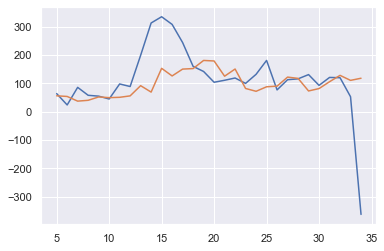

In [178]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
actual_deaths = weekly_deaths_df[weekly_deaths_df['week'] > 4].groupby([ 'week'])['excess_deaths_per100k'].sum()
actual_deaths_df = actual_deaths.to_frame(name = 'actual_excess_deaths').reset_index()
pred_deaths = predicted_df_all_days.groupby(['Week'])['Predicted_Weekly_Deaths'].sum()
pred_deaths_df = pred_deaths.to_frame(name = 'pred_excess_deaths').reset_index()

x = actual_deaths_df['week']
y = actual_deaths_df['actual_excess_deaths']
z = pred_deaths_df['pred_excess_deaths']
plt.plot(x, y)
plt.plot(x, z)

#x = weekly_deaths_df[(weekly_deaths_df['county'] == 8031.0) & (weekly_deaths_df['week'] > 4)]['week']
#y = weekly_deaths_df[(weekly_deaths_df['county'] == 8031.0) & (weekly_deaths_df['week'] > 4)]['excess_deaths_per100k']
#z = predicted_df_all_days[(predicted_df_all_days['FIPS'] == 8031.0)]['Predicted_Weekly_Deaths']
#plt.plot(x, y)
#plt.plot(x, z)

,county,year,week,ucod,total_deaths,excess_deaths
12570,8001.0,2020,0,C349,1,0
12576,8001.0,2020,0,F03,1,0
12583,8001.0,2020,0,I219,1,0
12584,8001.0,2020,0,I251,1,-1
12587,8001.0,2020,0,I64,2,1
...,...,...,...,...,...,...
163497,8125.0,2020,17,F03,1,0
163500,8125.0,2020,20,J449,1,0
163505,8125.0,2020,24,I219,1,0
163509,8125.0,2020,26,J449,1,0
